In [2]:
from gerrychain import Graph 
from gerrychain.tree import recursive_tree_part
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd

In [3]:
az_bg_connected = Graph.from_json("data/az-bg-connected.json")

In [4]:
POPULATION_KEY = "TOTPOP20"

In [5]:
total_population = sum(
    az_bg_connected.nodes[node][POPULATION_KEY] for node in az_bg_connected.nodes
)

## Districting Plan

In [6]:
n_districts = 30
ideal_population = total_population / n_districts

initial_plan = recursive_tree_part(
    az_bg_connected, range(n_districts), ideal_population, POPULATION_KEY, 0.02, 10
)

## Cut Edges

In [7]:
cutedges = 0
for e in az_bg_connected.edges():
    if initial_plan[e[0]] != initial_plan[e[1]]:
        cutedges += 1
print("Number of cutedges in initial_plan: ", cutedges)

Number of cutedges in initial_plan:  1485


## Latino Majority Districts

In [8]:
HISPANIC_POPULATION_KEY = "HISP20"

In [9]:
district_populations = np.zeros(n_districts)

for node in az_bg_connected.nodes:
    district_populations[initial_plan[node]] += az_bg_connected.nodes[node][
        POPULATION_KEY
    ]

district_populations

array([235750., 239477., 239496., 238479., 235723., 237529., 240302.,
       236918., 240166., 235576., 243138., 237668., 240493., 238150.,
       234306., 239042., 236342., 238642., 241436., 238166., 241346.,
       236878., 241913., 237725., 238022., 235351., 236427., 237297.,
       239611., 240133.])

In [10]:
latino_district_populations = np.zeros(n_districts)

for node in az_bg_connected.nodes:
    latino_district_populations[initial_plan[node]] += az_bg_connected.nodes[node][
        HISPANIC_POPULATION_KEY
    ]

latino_district_populations

array([133923.,  64111.,  73220.,  35909.,  72041.,  62957.,  48221.,
        57304., 161430.,  50176.,  25916.,  38913., 142839.,  77930.,
        44723.,  91254.,  48020.,  40706., 103636.,  85920., 150098.,
        18972.,  78695.,  65218.,  48217.,  17106.,  46215.,  73854.,
       150954.,  83775.])

In [11]:
LATINO_POPULATION_proportion = latino_district_populations / district_populations

num_majority_latino_districts = sum(LATINO_POPULATION_proportion > 0.5)

num_majority_latino_districts

5

## Pretty Map

In [12]:
LONGITUDE_KEY = "INTPTLON20"
LATITUDE_KEY = "INTPTLAT20"

In [13]:
position_dict = {
    v: (
        float(az_bg_connected.nodes[v][LONGITUDE_KEY]),
        float(az_bg_connected.nodes[v][LATITUDE_KEY]),
    )
    for v in az_bg_connected.nodes
}

In [14]:
x = np.array([initial_plan[v] for v in az_bg_connected.nodes()])

/Users/mschulist/miniconda3/envs/cse217a/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


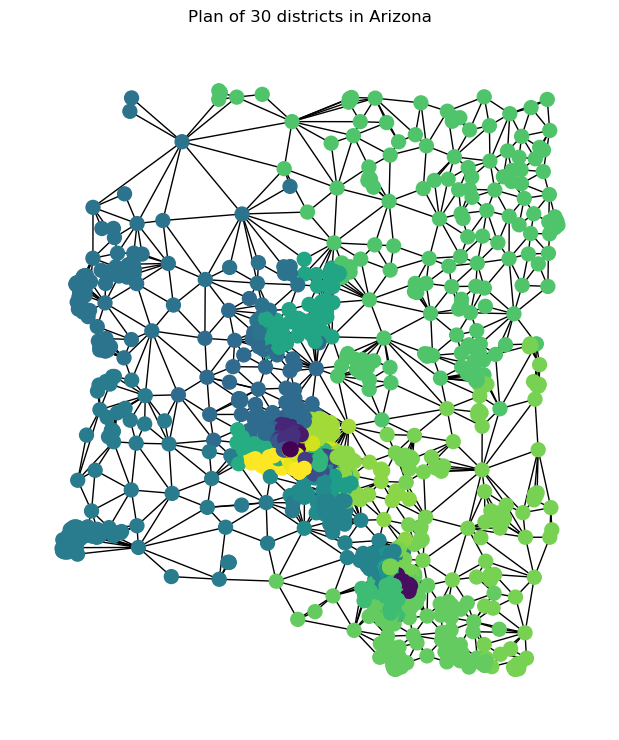

In [15]:
plt.figure(figsize=(6, 7))
node_colors = np.array([initial_plan[v] for v in az_bg_connected.nodes()])
nx.draw(
    az_bg_connected,
    node_size=100,
    node_color=node_colors,
    pos=position_dict,
)
plt.title(f"Plan of {n_districts} districts in Arizona")
plt.show()

## Cool Map

In [16]:
ip_list = [[i, p] for (i, p) in initial_plan.items()]

plan_gdf = gpd.GeoDataFrame(ip_list, columns=["graph_id", "district"])

In [17]:
geoids = []
for i, row in plan_gdf.iterrows():
    geoids.append(int(az_bg_connected.nodes[row["graph_id"]]["GEOID20"]))

plan_gdf["GEOID"] = geoids

In [18]:
az_bg_map: gpd.GeoDataFrame = gpd.read_file("data/tl_2023_04_bg")

az_bg_map["GEOID"] = az_bg_map["GEOID"].astype(int)

az_bg_map = az_bg_map.merge(plan_gdf, on="GEOID")

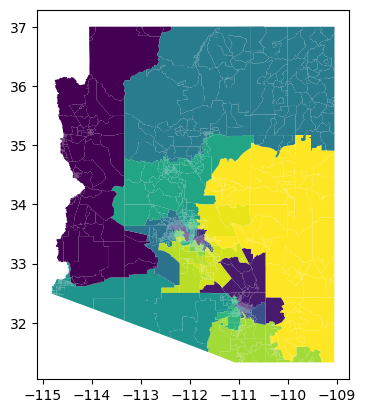

In [85]:
az_bg_map.plot(column="district")
plt.show()

## ReComb (not for HW)

In [22]:
from gerrychain import Partition
from gerrychain.updaters import cut_edges, Tally
from gerrychain.proposals import recom

In [23]:
inital_partition = Partition(
    graph=az_bg_connected,
    assignment=initial_plan,
    updaters={
        "our_cut_edges": cut_edges,
        "population": Tally(POPULATION_KEY, alias="population"),
        "district_latino_population": Tally(
            HISPANIC_POPULATION_KEY, alias="district_latino_population"
        ),
    },
)